# Perceval Detailed Walkthrough

In this notebook, we aim to reproduce the $\mathsf{CNOT}$ Gate to 
evaluate its performance while demonstrating key features of Perceval. We use as basis the implementation from [1]

In [14]:
import perceval as pcvl
import perceval.lib.phys as phys
import sympy as sp
import numpy as np

### Ralph CNOT Gate

We start by describing the circuit as defined by the paper above- it is a circuit on six modes (labelled from 0 to 5 from top to bottom) consisting of five beam splitters. Modes 1 and 2 contain the control system while modes 3 and 4 encode the target syestem. Modes 0 and 5 are unoccupied ancillary modes.

In [4]:
cnot = phys.Circuit(6, name="Ralph CNOT")
cnot.add((0, 1), phys.BS(R=1/3, phi_b=sp.pi, phi_d=0))
cnot.add((3, 4), phys.BS(R=1/2))
cnot.add((2, 3), phys.BS(R=1/3, phi_b=sp.pi, phi_d=0))
cnot.add((4, 5), phys.BS(R=1/3))
cnot.add((3, 4), phys.BS(R=1/2))
pcvl.pdisplay(cnot)

We can then simulate this circuit using the `Naive` backend on four different input states corresponding to the two-qubit computational basis states. We use `CircuitAnalyser` to analyse the performance of the gate.

In [5]:
simulator_backend = pcvl.BackendFactory().get_backend("Naive")
s_cnot = simulator_backend(cnot.U)

states = {
    pcvl.BasicState([0, 1, 0, 1, 0, 0]): "00",
    pcvl.BasicState([0, 1, 0, 0, 1, 0]): "01",
    pcvl.BasicState([0, 0, 1, 1, 0, 0]): "10",
    pcvl.BasicState([0, 0, 1, 0, 1, 0]): "11"
}

ca = pcvl.CircuitAnalyser(s_cnot, states)
ca.compute(expected={"00": "00", "01": "01", "10": "11", "11": "10"})
pcvl.pdisplay(ca)
print("performance=%s, error rate=%.3f%%" % (pcvl.simple_float(ca.performance)[1], ca.error_rate))

,00,01,10,11
00,0.999991,0,0,0
01,0,0.999991,0,0
10,0,0,0,0.999991
11,0,0,0.999991,0


performance=1/9, error rate=0.000%


Beyond the actual logic function, what is interesting with this gate us that it produces entangled states that we will be trying to check with CHSH experiment when the source is not perfect.

### Checking for entanglement with CHSH experiment
![https://en.wikipedia.org/wiki/File:Two_channel_bell_test.svg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Two_channel_bell_test.svg/1340px-Two_channel_bell_test.svg.png)
*https://en.wikipedia.org/wiki/File:Two_channel_bell_test.svg*

To reproduce this Bell test protocol, we define a new circuit which uses the $\mathsf{CNOT}$ gate implemented above as a sub-circuit. The parameters $a$ and $b$ describe the measurement bases used by players $A$ and $B$ in the runs of the Bell-test.

In [6]:
test_cnot = phys.Circuit(6)
test_cnot.add((1, 2), phys.BS())

test_cnot //= cnot

a = pcvl.Parameter("a")
b = pcvl.Parameter("b")

test_cnot.add((1, 2), phys.BS(theta=a))
test_cnot.add((3, 4), phys.BS(theta=b))

pcvl.pdisplay(test_cnot)

We start by setting the values of the two parameters to 0, meaning that the beam splitters after the $\mathsf{CNOT}$ effectively act as the identity. 

In [7]:
a.set_value(0)
b.set_value(0)

We now define a photon source with a brightness of 40% and a purity of 99%. We then define a `Processor` which plugs two such sources to the circuit above, on ports 2 and 3 (using the 0-index convention).

In [8]:
source = pcvl.Source(brightness=0.40, purity=0.99)
QPU = pcvl.Processor({2:source, 3:source}, test_cnot)

We now detail the different state vectors that are the probabilistic inputs to the circuit. The most frequent input is the empty state, followed by two states with only a single photon on either of the input ports, then by the expected nominal input $|0,0,1,1,0,0\rangle$.

In [9]:
pcvl.pdisplay(QPU.source_distribution, precision=1e-4)

state,probability
"|0,0,0,0,0,0>",9/25
"|0,0,0,1,0,0>",0.2376
"|0,0,1,0,0,0>",0.2376
"|0,0,1,1,0,0>",0.1568
"|0,0,0,2,0,0>",0.0024
"|0,0,2,0,0,0>",0.0024
"|0,0,2,1,0,0>",0.0016
"|0,0,1,2,0,0>",0.0016
"|0,0,2,2,0,0>",0


We can then check the output state distribution corresponding to this input distribution.

In [10]:
_, output_distribution=QPU.run(simulator_backend)
pcvl.pdisplay(output_distribution, max_v=10)

state,probability
"|0,0,0,0,0,0>",9/25
"|0,0,0,1,0,0>",0.1188
"|0,0,1,0,0,0>",0.1188
"|0,0,0,0,0,1>",0.0792
"|1,0,0,0,0,0>",0.0792
"|0,0,0,0,1,0>",0.0396
"|0,1,0,0,0,0>",0.0396
"|0,0,2,0,0,0>",0.017757
"|0,0,0,2,0,0>",0.017757
"|1,0,1,0,0,0>",0.017691


Let us run now the experiment with decreasing value of purity in the range $[0.98,1]$ and check the CHSH inequality.

In [11]:
from tqdm.auto import tqdm
x = np.arange(0, 2, 0.05)
y = []

for imp in tqdm(x):
    Es = []
    for va in [0, sp.pi/4]:
        a.set_value(va)
        for vb in [sp.pi/8, 3*sp.pi/8]:
            b.set_value(vb)
            Npp, Npm, Nmp, Nmm = 0, 0, 0, 0
            source = pcvl.Source(brightness=0.15, purity=1-imp/100)
            # we add a post-selection on the processor, there needs to be zero photon in the ancilla modes 1,6
            # and exactly one in mode 2,3 and one in mode 3,4
            QPU = pcvl.Processor({2:source, 3:source},
                                 test_cnot, lambda o: o[0]==0 and (o[1]+o[2]==1) and (o[3]+o[4]==1) and o[5]==0)
            _, output_distribution=QPU.run(simulator_backend)
            for output_sv, prob in output_distribution.items():
                output_state = output_sv[0]
                if (output_state[1] == 1 and output_state[3] == 1):
                    Npp = prob
                if (output_state[1] == 1 and output_state[4] == 1):
                    Npm = prob
                if (output_state[2] == 1 and output_state[3] == 1):
                    Nmp = prob
                if (output_state[2] == 1 and output_state[4] == 1):
                    Nmm = prob
            E = (Npp-Npm-Nmp+Nmm)/(Npp+Npm+Nmp+Nmm)
            Es.append(E)

    S = Es[0]-Es[1]+Es[2]+Es[3]
    print("purity=",1-imp/100, "S=", S)
    y.append(S)

  0%|          | 0/40 [00:00<?, ?it/s]

purity= 1.0 S= 2.82842712474619
purity= 0.9995 S= 2.7808356540538646
purity= 0.999 S= 2.734207894156242
purity= 0.9985 S= 2.6885149340967027
purity= 0.998 S= 2.643729007886132
purity= 0.9975 S= 2.5998234383781567
purity= 0.997 S= 2.5567725844135643
purity= 0.9965 S= 2.514551791014185
purity= 0.996 S= 2.4731373424226386
purity= 0.9955 S= 2.43250641780031
purity= 0.995 S= 2.39263704940936
purity= 0.9945 S= 2.3535080831180633
purity= 0.994 S= 2.315099141079988
purity= 0.9935 S= 2.2773905864489574
purity= 0.993 S= 2.2403634900011484
purity= 0.9925 S= 2.2039995985453884
purity= 0.992 S= 2.1682813050106344
purity= 0.9915 S= 2.133191620107884
purity= 0.991 S= 2.0987141454704616
purity= 0.9905 S= 2.0648330481836887
purity= 0.99 S= 2.0315330366205884
purity= 0.9895 S= 1.998799337506385
purity= 0.989 S= 1.966617674139276
purity= 0.9885 S= 1.9349742457002677
purity= 0.988 S= 1.9038557075888378
purity= 0.9875 S= 1.8732491527257935
purity= 0.987 S= 1.8431420937680647
purity= 0.9865 S= 1.81352244618

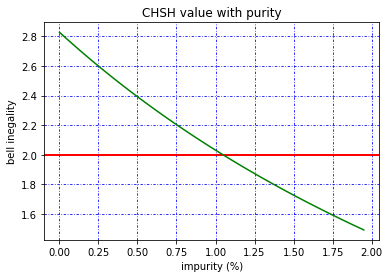

In [12]:
import matplotlib.pyplot as plt
plt.title("CHSH value with purity")
plt.xlabel("impurity (%)")
plt.ylabel("bell inegality")
plt.axhline(y=2, linewidth=2, color="red", label= 'horizontal-line')
plt.plot(x, y, color ="green")
plt.grid(color='b', dashes=(3, 2, 1, 2))
plt.show()

Beyond only 1% of impurity, we are crossing the value $2$, ie not violating anymore the $|CHSH|\le 2$ inegality!

[1] T. C. Ralph, N. K. Langford, T. B. Bell, and A. G. White. Linear optical controlled-NOT gate in the coincidence basis. Physical Review A, 65(6):062324, June 2002. Publisher: American Physical Society. URL: https://link.aps.org/doi/10.1103/PhysRevA.65.062324